 Import packages and Data

In [3]:
from surprise import Reader, Dataset, SVD, evaluate
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols, index_col='movie_id', encoding='latin-1')

m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url','unknown', 'Action', 'Adventure',\
          'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy','Film-Noir', 'Horror',\
          'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, index_col=0, encoding='latin-1')

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1', parse_dates=True)

In [4]:
from datetime import datetime

ratings['unix_timestamp'] = ratings['unix_timestamp'].apply(datetime.fromtimestamp)
ratings.columns = ['user_id', 'rating', 'time']
ratings.head(10)

,user_id,rating,time
movie_id,,,
242,196,3,1997-12-04 10:55:49
302,186,3,1998-04-04 14:22:22
377,22,1,1997-11-07 02:18:36
51,244,2,1997-11-27 00:02:03
346,166,1,1998-02-02 00:33:16
474,298,4,1998-01-07 09:20:06
265,115,2,1997-12-03 12:51:28
465,253,5,1998-04-03 13:34:27
451,305,3,1998-02-01 04:20:17


Here we can see how ratings distributed.

In [5]:
ratings['rating'].hist(bins=9)

So far we will only use the movie title from this DataFrame. We may need the types of the movie later in our model.

In [6]:
movies['release_date'] = pd.to_datetime(movies['release_date'])
movies.head(10)

,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,1995-01-01,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Twelve Monkeys (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,Babe (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
9,Dead Man Walking (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
for i in users['occupation'].unique():
    users[i] = users['occupation'] == i
users.drop('occupation', axis=1, inplace=True)
users.head(10)

KeyError: 'occupation'

For each movie we count how many ratings it got, and what's the mean and standard deviation.

In [9]:
ratings_movie_summary = ratings.groupby('movie_id')['rating'].agg(['count', 'mean', 'std'])
ratings_movie_summary.head(10)

,count,mean,std
movie_id,,,
1,452,3.878319,0.927897
2,131,3.206107,0.966497
3,90,3.033333,1.212760
4,209,3.550239,0.965069
5,86,3.302326,0.946446
6,26,3.576923,1.301478
7,392,3.798469,0.982037
8,219,3.995434,1.002281
9,299,3.896321,1.042368


For each user, we count how many ratings he or she gives, and the mean and standard deviation as well.

In [10]:
ratings_user_summary = ratings.groupby('user_id')['rating'].agg(['count', 'mean', 'std'])
ratings_user_summary.head(10)

,count,mean,std
user_id,,,
1,272,3.610294,1.263585
2,62,3.709677,1.030472
3,54,2.796296,1.219026
4,24,4.333333,0.916831
5,175,2.874286,1.362963
6,211,3.635071,1.039461
7,403,3.965261,1.064480
8,59,3.796610,1.242629
9,22,4.272727,0.935125


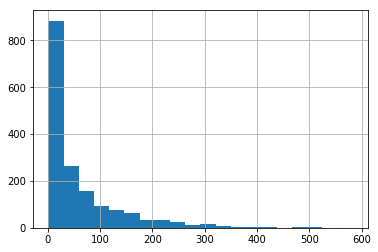

In [11]:
ratings_movie_summary.sort_values(by='count')['count'].hist(bins=20)

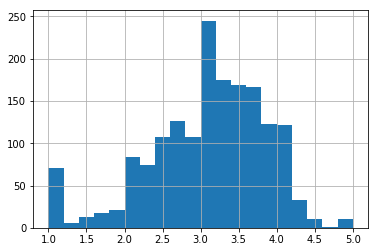

In [12]:
ratings_movie_summary.sort_values(by='mean')['mean'].hist(bins=20)

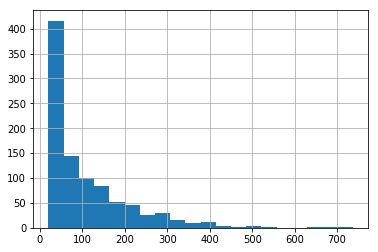

In [13]:
ratings_user_summary.sort_values(by='count')['count'].hist(bins=20)

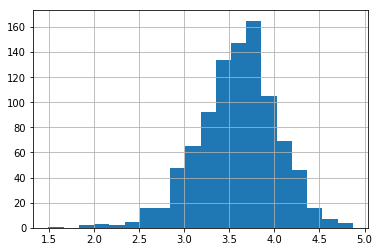

In [14]:
ratings_user_summary.sort_values(by='mean')['mean'].hist(bins=20)

We create a pivot table for ratings and store the total mean and standard deviation values.

In [15]:
ratings_p = pd.pivot_table(ratings, values='rating', index='user_id', columns='movie_id')
ratings_p.iloc[:10, :10]

movie_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4.0,NaN
7,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,4.0
8,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN


In [16]:
mean = ratings_p.stack().mean()
std = ratings_p.stack().std()

**Notations:**

$\mu_i$ : The mean of all ratings received by movie i.

$\mu_u$ : The mean of all ratings from user u.

$\mu$ : The mean of all ratings.

$\sigma_i$ : The standard deviation of all ratings received by movie i.

$\sigma_u$ : The standard deviation of all ratings from user u.

$r_{ui}$ : User u's rating on movie i.

$\hat{r}_{ui}$ : Prediction about user u's rating on movie i.

$N^k_u(i)$ : k nearest neighbors of movie i, that are rated by user u.

- **Baseline Model**

In the first baseline model, we predict the rating from a specific user on a specific movie, just by the average rating that a movie receives, with adjustment by how this user's average rating compared with the total average.

$$\hat{r}_{ui} = \mu_u + \mu_i - \mu$$

In [17]:
movie_mean = np.ones(ratings_p.shape)
movie_mean = pd.DataFrame(movie_mean * np.array(ratings_movie_summary['mean']).reshape(1,1682))
user_mean = np.ones(ratings_p.T.shape)
user_mean = pd.DataFrame(user_mean * np.array(ratings_user_summary['mean'])).T
pred = movie_mean + user_mean - mean
score = abs(np.array(ratings_p) - pred)
score_2 = score ** 2
print('RMSE: {:.4f}'.format(np.sqrt(score_2.stack().mean())))
print('MAE: {:.4f}'.format(score.stack().mean()))

RMSE: 0.9384
MAE: 0.7384


Since we don't have train-test-split in our prediction, we are actually using the mean of the data to predict every single data. Therefore, the score might be biased because of data leakage. So we do cross-validation on the model.

In [18]:
from sklearn.model_selection import KFold

kfolds = KFold(n_splits = 5, random_state = 13)
rmse = []
mae = []
i = 0
print('Evaluating RMSE, MAE of the Baseline Model. \n')
print('-'*12)
for train_index, test_index in kfolds.split(ratings):
    train = ratings.copy()
    test = ratings.copy()
    train['rating'].iloc[test_index] = np.NaN
    test['rating'].iloc[train_index] = np.NaN
    train_movie_summary = train.groupby('movie_id')['rating'].agg(['count', 'mean', 'std'])
    train_user_summary = train.groupby('user_id')['rating'].agg(['count', 'mean', 'std'])
    test_p = pd.pivot_table(test, values='rating', index='user_id', columns='movie_id', dropna=False)
    movie_mean = np.ones(ratings_p.shape)
    movie_mean = pd.DataFrame(movie_mean * np.array(train_movie_summary['mean']).reshape(1,1682))
    user_mean = np.ones(ratings_p.T.shape)
    user_mean = pd.DataFrame(user_mean * np.array(train_user_summary['mean'])).T
    train_p = movie_mean + user_mean - mean
    score = abs(np.array(test_p) - train_p)
    score_2 = score ** 2
    rmse += [np.sqrt(score_2.stack().mean())]
    mae += [score.stack().mean()]
    i += 1
    print('Fold', i)
    print('RMSE: {:.4f}'.format(np.sqrt(score_2.stack().mean())))
    print('MAE: {:.4f}'.format(score.stack().mean()))
    print('-'*12)
print('-'*12)
print('Mean RMSE: {:.4f}'.format(np.mean(rmse)))
print('Mean MAE: {:.4f}'.format(np.mean(mae)))
print('-'*12)
print('-'*12)

Evaluating RMSE, MAE of the Baseline Model. 

------------


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Fold 1
RMSE: 0.9798
MAE: 0.7709
------------
Fold 2
RMSE: 0.9706
MAE: 0.7599
------------
Fold 3
RMSE: 0.9684
MAE: 0.7602
------------
Fold 4
RMSE: 0.9638
MAE: 0.7564
------------
Fold 5
RMSE: 0.9635
MAE: 0.7606
------------
------------
Mean RMSE: 0.9692
Mean MAE: 0.7616
------------
------------


- **Baseline_Plus Model**

In the second model, we want to do it slightly better using z-score.

$$\hat{r}_{ui} = \mu_u + \sigma_u * \frac{(\mu_i - \mu)}{\sigma}$$

In [19]:
movie_mean = np.ones(ratings_p.shape)
movie_mean = pd.DataFrame(movie_mean * np.array(ratings_movie_summary['mean']).reshape(1,1682))
user_mean = np.ones(ratings_p.T.shape)
user_mean = pd.DataFrame(user_mean * np.array(ratings_user_summary['mean'])).T
user_std = np.ones(ratings_p.T.shape)
user_std = pd.DataFrame(user_std * np.array(ratings_user_summary['std'])).T
pred_plus = user_mean + (movie_mean - mean)/std * user_std
score_plus = abs(np.array(ratings_p) - pred_plus)
score_2_plus = score_plus ** 2
print('RMSE: {:.4f}'.format(np.sqrt(score_2_plus.stack().mean())))
print('MAE: {:.4f}'.format(score_plus.stack().mean()))

RMSE: 0.9345
MAE: 0.7339


Use our baseline model to recommend movies for user 196.

In [20]:
user_196 = movies[['title', 'release_date']]
user_196['Estimate_Score'] = np.array(pred_plus.loc[195])
user_196 = user_196.sort_values('Estimate_Score', ascending=False)
print(user_196.head(10))

                                                      title release_date  \
movie_id                                                                   
814                           Great Day in Harlem, A (1994)   1994-01-01   
1599                          Someone Else's America (1995)   1996-05-10   
1201             Marlene Dietrich: Shadow and Light (1996)    1996-04-02   
1122                         They Made Me a Criminal (1939)   1939-01-01   
1653      Entertaining Angels: The Dorothy Day Story (1996)   1996-09-27   
1293                                        Star Kid (1997)   1998-01-16   
1500                              Santa with Muscles (1996)   1996-11-08   
1189                                     Prefontaine (1997)   1997-01-24   
1536                                   Aiqing wansui (1994)   1996-07-22   
1467                   Saint of Fort Washington, The (1993)   1993-01-01   

          Estimate_Score  
movie_id                  
814             4.942375  
1599  

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Here is the cross-validation score for our second model

In [21]:
rmse_plus = []
mae_plus = []
i = 0
print('Evaluating RMSE, MAE of the Baseline_Plus Model. \n')
print('-'*12)
for train_index, test_index in kfolds.split(ratings):
    train = ratings.copy()
    test = ratings.copy()
    train['rating'].iloc[test_index] = np.NaN
    test['rating'].iloc[train_index] = np.NaN
    train_movie_summary = train.groupby('movie_id')['rating'].agg(['count', 'mean', 'std'])
    train_user_summary = train.groupby('user_id')['rating'].agg(['count', 'mean', 'std'])
    test_p = pd.pivot_table(test, values='rating', index='user_id', columns='movie_id', dropna=False)
    movie_mean = np.ones(ratings_p.shape)
    movie_mean = pd.DataFrame(movie_mean * np.array(train_movie_summary['mean']).reshape(1,1682))
    user_mean = np.ones(ratings_p.T.shape)
    user_mean = pd.DataFrame(user_mean * np.array(train_user_summary['mean'])).T
    user_std = np.ones(ratings_p.T.shape)
    user_std = pd.DataFrame(user_std * np.array(train_user_summary['std'])).T
    train_p = user_mean + (movie_mean - mean)/std * user_std
    score = abs(np.array(test_p) - train_p)
    score_2 = score ** 2
    rmse_plus += [np.sqrt(score_2.stack().mean())]
    mae_plus += [score.stack().mean()]
    i += 1
    print('Fold', i)
    print('RMSE: {:.4f}'.format(np.sqrt(score_2.stack().mean())))
    print('MAE: {:.4f}'.format(score.stack().mean()))
    print('-'*12)
print('-'*12)
print('Mean RMSE: {:.4f}'.format(np.mean(rmse_plus)))
print('Mean MAE: {:.4f}'.format(np.mean(mae_plus)))
print('-'*12)
print('-'*12)

Evaluating RMSE, MAE of the Baseline_Plus Model. 

------------


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Fold 1
RMSE: 0.9759
MAE: 0.7665
------------
Fold 2
RMSE: 0.9687
MAE: 0.7569
------------
Fold 3
RMSE: 0.9631
MAE: 0.7544
------------
Fold 4
RMSE: 0.9597
MAE: 0.7516
------------
Fold 5
RMSE: 0.9597
MAE: 0.7570
------------
------------
Mean RMSE: 0.9654
Mean MAE: 0.7573
------------
------------


- **Baseline Model with SVM/Gradient Boosting**

We can improve this model even more, by applying SVM regressor or Gradient Boosting on each approximation, instead of just using z-score.

- SVM

In [22]:
from sklearn.svm import SVR

movie_mean = np.ones(ratings_p.shape)
movie_mean = pd.DataFrame(movie_mean * np.array(ratings_movie_summary['mean']).reshape(1,1682))
X = np.array(ratings_p*0) + movie_mean
svm = SVR(gamma=1, C=1)
pred_svm = ratings_p.copy()
for i in range(ratings_p.shape[0]):
    svm.fit(np.array(X.iloc[i].dropna()).reshape(-1,1), ratings_p.iloc[i].dropna())
    pred_svm.iloc[i] = svm.predict(np.array(movie_mean.iloc[0]).reshape(-1,1))
score_svm = abs(np.array(ratings_p) - pred_svm)
score_2_svm = score_svm ** 2
print('RMSE: {:.4f}'.format(np.sqrt(score_2_svm.stack().mean())))
print('MAE: {:.4f}'.format(score_svm.stack().mean()))

RMSE: 0.9105
MAE: 0.6748


Use our svm model to recommend movies for user 196.

In [23]:
user_196_svm = movies[['title', 'release_date']]
user_196_svm['Estimate_Score'] = np.array(pred_svm.loc[195])
user_196_svm = user_196_svm.sort_values('Estimate_Score', ascending=False)
print(user_196_svm.head(10))

                                                      title release_date  \
movie_id                                                                   
1398                                            Anna (1996)   1996-11-13   
119                  Maya Lin: A Strong Clear Vision (1994)   1994-01-01   
1594                                         Everest (1998)   1998-03-10   
1642                               Some Mother's Son (1996)   1996-12-27   
408                                   Close Shave, A (1995)   1996-04-28   
318                                 Schindler's List (1993)   1993-01-01   
169                              Wrong Trousers, The (1993)   1993-01-01   
483                                       Casablanca (1942)   1942-01-01   
1449                                 Pather Panchali (1955)   1996-03-22   
114       Wallace & Gromit: The Best of Aardman Animatio...   1996-04-05   

          Estimate_Score  
movie_id                  
1398            4.454999  
119   

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Cross-Validation

In [24]:
rmse_svm = []
mae_svm = []
fold = 0
movie_mean = pd.DataFrame(np.ones(ratings_p.shape) * np.array(ratings_movie_summary['mean']).reshape(1,1682))
print('Evaluating RMSE, MAE of the Baseline_SVM Model. \n')
print('-'*12)
for train_index, test_index in kfolds.split(ratings):
    train = ratings.copy()
    test = ratings.copy()
    train['rating'].iloc[test_index] = np.NaN
    test['rating'].iloc[train_index] = np.NaN
    train_movie_summary = train.groupby('movie_id')['rating'].agg(['count', 'mean', 'std'])
    train_user_summary = train.groupby('user_id')['rating'].agg(['count', 'mean', 'std'])
    train_p = pd.pivot_table(train, values='rating', index='user_id', columns='movie_id', dropna=False)
    test_p = pd.pivot_table(test, values='rating', index='user_id', columns='movie_id', dropna=False)
    train_mean = pd.DataFrame(np.ones(ratings_p.shape) * np.array(train_movie_summary['mean']).reshape(1,1682))
    X = np.array(train_p*0) + train_mean
    pred = ratings_p.copy()
    for i in range(ratings_p.shape[0]):
        svm.fit(np.array(X.iloc[i].dropna()).reshape(-1,1), train_p.iloc[i].dropna())
        pred.iloc[i] = svm.predict(np.array(movie_mean.iloc[0]).reshape(-1,1))
    score = abs(np.array(test_p) - pred)
    score_2 = score ** 2
    rmse_svm += [np.sqrt(score_2.stack().mean())]
    mae_svm += [score.stack().mean()]
    fold += 1
    print('Fold', fold)
    print('RMSE: {:.4f}'.format(np.sqrt(score_2.stack().mean())))
    print('MAE: {:.4f}'.format(score.stack().mean()))
    print('-'*12)
print('-'*12)
print('Mean RMSE: {:.4f}'.format(np.mean(rmse_svm)))
print('Mean MAE: {:.4f}'.format(np.mean(mae_svm)))
print('-'*12)
print('-'*12)

Evaluating RMSE, MAE of the Baseline_SVM Model. 

------------


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Fold 1
RMSE: 0.9622
MAE: 0.7220
------------
Fold 2
RMSE: 0.9499
MAE: 0.7094
------------
Fold 3
RMSE: 0.9475
MAE: 0.7130
------------
Fold 4
RMSE: 0.9435
MAE: 0.7114
------------
Fold 5
RMSE: 0.9447
MAE: 0.7151
------------
------------
Mean RMSE: 0.9496
Mean MAE: 0.7142
------------
------------


Gradient Boosting

In [25]:
from xgboost import XGBRegressor

movie_mean = np.ones(ratings_p.shape)
movie_mean = pd.DataFrame(movie_mean * np.array(ratings_movie_summary['mean']).reshape(1,1682))
X = np.array(ratings_p*0) + movie_mean
xgb = XGBRegressor(learning_rate=0.1, max_depth=2, min_child_weight=10, gamma=1)
pred_xgb = ratings_p.copy()
for i in range(ratings_p.shape[0]):
    xgb.fit(np.array(X.iloc[i].dropna()).reshape(-1,1), ratings_p.iloc[i].dropna())
    pred_xgb.iloc[i] = xgb.predict(np.array(movie_mean.iloc[0]).reshape(-1,1))
score_xgb = abs(np.array(ratings_p) - pred_xgb)
score_2_xgb = score_xgb ** 2
print('RMSE: {:.4f}'.format(np.sqrt(score_2_xgb.stack().mean())))
print('MAE: {:.4f}'.format(score_xgb.stack().mean()))

ModuleNotFoundError: No module named 'xgboost'

Cross-Validation

In [ ]:
rmse_xgb = []
mae_xgb = []
fold = 0
movie_mean = pd.DataFrame(np.ones(ratings_p.shape) * np.array(ratings_movie_summary['mean']).reshape(1,1682))
print('Evaluating RMSE, MAE of the Baseline_XGB Model. \n')
print('-'*12)
for train_index, test_index in kfolds.split(ratings):
    train = ratings.copy()
    test = ratings.copy()
    train['rating'].iloc[test_index] = np.NaN
    test['rating'].iloc[train_index] = np.NaN
    train_movie_summary = train.groupby('movie_id')['rating'].agg(['count', 'mean', 'std'])
    train_user_summary = train.groupby('user_id')['rating'].agg(['count', 'mean', 'std'])
    train_p = pd.pivot_table(train, values='rating', index='user_id', columns='movie_id', dropna=False)
    test_p = pd.pivot_table(test, values='rating', index='user_id', columns='movie_id', dropna=False)
    train_mean = pd.DataFrame(np.ones(ratings_p.shape) * np.array(train_movie_summary['mean']).reshape(1,1682))
    X = np.array(train_p*0) + train_mean
    pred = ratings_p.copy()
    for i in range(ratings_p.shape[0]):
        xgb.fit(np.array(X.iloc[i].dropna()).reshape(-1,1), train_p.iloc[i].dropna())
        pred.iloc[i] = xgb.predict(np.array(movie_mean.iloc[0]).reshape(-1,1))
    score = abs(np.array(test_p) - pred)
    score_2 = score ** 2
    rmse_xgb += [np.sqrt(score_2.stack().mean())]
    mae_xgb += [score.stack().mean()]
    fold += 1
    print('Fold', fold)
    print('RMSE: {:.4f}'.format(np.sqrt(score_2.stack().mean())))
    print('MAE: {:.4f}'.format(score.stack().mean()))
    print('-'*12)
print('-'*12)
print('Mean RMSE: {:.4f}'.format(np.mean(rmse_xgb)))
print('Mean MAE: {:.4f}'.format(np.mean(mae_xgb)))
print('-'*12)
print('-'*12)

- **Pearsons'R Correlation Model**

We might also want to recommend movies just for a specific movie. Like the recommendation list showed on the webpage of a specific movie.

Here we recommend new movies based on the Pearsons'R correlation between movies.

In [ ]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = movies[movies['title'] == movie_title].index[0]
    target = ratings_p[i]
    similar_to_target = ratings_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(movies).join(ratings_movie_summary)\
                  [['PearsonR', 'title', 'count', 'mean']]
    print (corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [ ]:
recommend('Shawshank Redemption, The (1994)', 10)

- **K-Nearest Neighbor (kNN) Model**

We can treat the **Pearsons' R Correlation** between movies as the distance, and using these distances to build a **K-Nearest Neighbor model**.

Notations:

$r_{ui}$ : User u's rating on movie i.

$\hat{r}_{ui}$ : Prediction about user u's rating on movie i.

$N^k_u(i)$ : k nearest neighbors of movie i, that are rated by user u.

Then we can have our kNN model as:

$$\hat{r}_{ui} = \frac{\sum_{j \in N^k_u(i)} corr(i, j) * r_{uj}}{\sum_{j \in N^k_u(i)} corr(i, j)}$$

In [ ]:
sim = ratings_p.corr().abs()
sim.iloc[:10, :10]

In [ ]:
knn_pred = ratings_p.copy()
for i in ratings_p.index:
    N = sim.loc[ratings[ratings['user_id'] == i].index]
    for j in ratings_p.columns:
        try:
            N_k = N[j].sort_values(ascending=False).drop(j)[:30]
        except:
            N_k = N[j].sort_values(ascending=False)[:30]
        weighted_rating = N_k*ratings_p.loc[i, N_k.index]
        knn_pred.loc[i, j] = weighted_rating.sum()/N_k.sum()

knn_pred.iloc[:10, :10]

In [ ]:
score_knn = abs(np.array(ratings_p) - knn_pred)
score_2_knn = score_knn ** 2
print('RMSE: {:.4f}'.format(np.sqrt(score_2_knn.stack().mean())))
print('MAE: {:.4f}'.format(score_knn.stack().mean()))

train-test split score

In [ ]:
train = ratings.copy()
test = ratings.copy()
train['rating'].iloc[80000:] = np.NaN
test['rating'].iloc[:80000] = np.NaN
train_movie_summary = train.groupby('movie_id')['rating'].agg(['count', 'mean', 'std'])
train_user_summary = train.groupby('user_id')['rating'].agg(['count', 'mean', 'std'])
train_p = pd.pivot_table(train, values='rating', index='user_id', columns='movie_id', dropna=False)
test_p = pd.pivot_table(test, values='rating', index='user_id', columns='movie_id', dropna=False)

knn_pred = ratings_p.copy()
for i in ratings_p.index:
    if i % 100 == 0:
        print(i)
    N = sim.loc[train[train['user_id'] == i].index]
    for j in ratings_p.columns:
        try:
            N_k = N[j].sort_values(ascending=False).drop(j)[:30]
        except:
            N_k = N[j].sort_values(ascending=False)[:30]
        weighted_rating = N_k*train_p.loc[i, N_k.index]
        knn_pred.loc[i, j] = weighted_rating.sum()/N_k.sum()

score_knn = abs(np.array(ratings_p) - knn_pred)
score_2_knn = score_knn ** 2
print('RMSE: {:.4f}'.format(np.sqrt(score_2_knn.stack().mean())))
print('MAE: {:.4f}'.format(score_knn.stack().mean()))

- **kNN_Plus Model**

Now we can improve our KNN model just by the same trick we used on our baseline model: adjust by the z-score.

Notation:

$\mu_i$ : The mean of all ratings received by movie i.

$\sigma_i$ : The standard deviation of all ratings received by movie i.

$$\hat{r}_{ui} = \mu_i + \sigma_i * \frac{\sum_{j \in N^k_u(i)} corr(i, j) *( r_{uj} - \mu_j) / \sigma_j}{\sum_{j \in N^k_u(i)} corr(i, j)}$$

In [ ]:
knn_plus_pred = ratings_p.copy()
for i in ratings_p.index:
    N = sim.loc[ratings[ratings['user_id'] == i].index]
    for j in ratings_p.columns:
        try:
            N_k = N[j].sort_values(ascending=False).drop(j)[:30]
        except:
            N_k = N[j].sort_values(ascending=False)[:30]
        weighted_rating = N_k*(ratings_p.loc[i, N_k.index] - ratings_movie_summary.loc[N_k.index, 'mean'])/ ratings_movie_summary.loc[N_k.index, 'std']
        knn_plus_pred.loc[i, j] = weighted_rating.sum()/N_k.sum() * ratings_movie_summary.loc[j, 'std'] + ratings_movie_summary.loc[j, 'mean']

knn_plus_pred.iloc[:10, :10]

In [ ]:
score_knn_plus = abs(np.array(ratings_p) - knn_plus_pred)
score_2_knn_plus = score_knn ** 2
print('RMSE: {:.4f}'.format(np.sqrt(score_2_knn_plus.stack().mean())))
print('MAE: {:.4f}'.format(score_knn_plus.stack().mean()))

train-test split score.

In [ ]:
train = ratings.copy()
test = ratings.copy()
train['rating'].iloc[80001:] = np.NaN
test['rating'].iloc[:80001] = np.NaN
train_movie_summary = train.groupby('movie_id')['rating'].agg(['count', 'mean', 'std'])
train_user_summary = train.groupby('user_id')['rating'].agg(['count', 'mean', 'std'])
train_p = pd.pivot_table(train, values='rating', index='user_id', columns='movie_id', dropna=False)
test_p = pd.pivot_table(test, values='rating', index='user_id', columns='movie_id', dropna=False)

knn_plus_pred = ratings_p.copy()
for i in ratings_p.index:
    if i % 100 == 0:
        print(i)
    N = sim.loc[train[train['user_id'] == i].index]
    for j in ratings_p.columns:
        try:
            N_k = N[j].sort_values(ascending=False).drop(j)[:30]
        except:
            N_k = N[j].sort_values(ascending=False)[:30]
        weighted_rating = N_k*(train_p.loc[i, N_k.index] - train_movie_summary.loc[N_k.index, 'mean'])/ train_movie_summary.loc[N_k.index, 'std']
        knn_plus_pred.loc[i, j] = weighted_rating.sum()/N_k.sum() * train_movie_summary.loc[j, 'std'] + train_movie_summary.loc[j, 'mean']

score_knn = abs(np.array(ratings_p) - knn_plus_pred)
score_2_knn = score_knn ** 2
print('RMSE: {:.4f}'.format(np.sqrt(score_2_knn.stack().mean())))
print('MAE: {:.4f}'.format(score_knn.stack().mean()))

- **Supervised Learning Model**

Gradient Boosting as supervised learning.

I take each user-movie combination as one instance, and hence take full use of the features from the user and movie.

In [ ]:
from datetime import datetime

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('../input/ml-100k/u.data', sep='\t', names=r_cols, encoding='latin-1')
ratings['unix_timestamp'] = ratings['unix_timestamp'].apply(datetime.fromtimestamp)
ratings.columns = ['user_id', 'movie_id', 'rating', 'time']
ratings.head(10)

m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url','unknown', 'Action', 'Adventure',\
          'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy','Film-Noir', 'Horror',\
          'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../input/ml-100k/u.item', sep='|', names=m_cols, encoding='latin-1')

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
#occupation = {'none': 0, 'administrator': 1, 'artist': 2, 'doctor': 3, 'educator': 4, 'engineer': 5, 'entertainment': 6,\
#              'executive': 7, 'healthcare': 8, 'homemaker': 9, 'lawyer': 10, 'librarian': 11, 'marketing': 12,\
#              'programmer': 13, 'salesman': 14, 'scientist': 15, 'student': 16, 'technician': 17, 'writer': 18,\
#              'retired': 19, 'other': 20}
df = ratings_p.stack(dropna=False).reset_index()
df.columns = ['user_id', 'movie_id', 'rating']
df = df.merge(users, on='user_id')
df = df.merge(movies, on='movie_id')
df['sex'] = df['sex'].replace(['F', 'M'], [1, 0])
#df['occupation'] = df['occupation'].replace(occupation)
df.drop(['release_date', 'video_release_date', 'imdb_url', 'title', 'zip_code'], axis=1, inplace=True)
df_train = df.dropna()
df.head(10)

In [ ]:
rmse_reg = []
mae_reg = []
i = 0
print('Evaluating RMSE, MAE of the XGB_Reg Model. \n')
print('-'*12)
for train_index, test_index in kfolds.split(ratings):
    X_train = df_train.drop('rating', axis=1).iloc[train_index]
    y_train = df_train['rating'].iloc[train_index]
    X_test = df_train.drop('rating', axis=1).iloc[test_index]
    y_test = df_train['rating'].iloc[test_index]
    xgb = XGBRegressor(learning_rate=0.1, max_depth=10, min_child_weight=10, gamma=0.03).fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    score = abs(y_test - y_pred)
    score_2 = score**2
    rmse_reg += [np.sqrt(np.mean(score_2))]
    mae_reg += [np.mean(score)]
    i += 1
    print('Fold', i)
    print('RMSE: {:.4f}'.format(np.sqrt(np.mean(score_2))))
    print('MAE: {:.4f}'.format(np.mean(score)))
    print('-'*12)
print('-'*12)
print('Mean RMSE: {:.4f}'.format(np.mean(rmse_reg)))
print('Mean MAE: {:.4f}'.format(np.mean(mae_reg)))
print('-'*12)
print('-'*12)

The next model takes more than 6 hours to run. So I don't commit it this time. I'll move it into a seperate notebook.

- **Improvement on Gradient Boosting Model (?)**

In the previous model, we use rating as the target variable, therefore the model knows nothing about what ratings that the movie has received, and what ratings the user has given. Now we might want to include all related ratings, both from the same user and for the same movie, as features in our model.

This model takes a much longer time than others.

Notice that two of the slots on each row in these new features will actually contain the target value! However, I right now have no clue that this will result in data leakage since the model has no idea where these hidden correct ratings locate.

It makes sense that this model will beat all other models, since it contains more information like the age and gender of the user, genre of the movie, etc. However, it is still not safe to say that we are free of data leakage here. So I leave a question mark here.

In [ ]:
### BUG. Need Fix. ###

#df = df.merge(ratings_p, left_on='user_id', right_index=True)
#df = df.merge(ratings_p.T, left_on='movie_id', right_index=True)
#df.head(10)

In [ ]:
#df_train = df_train.merge(ratings_p, left_on='user_id', right_index=True)
#df_train = df_train.merge(ratings_p.T, left_on='movie_id', right_index=True)
#df_train.head(10)

In [ ]:
#for i in range(df_train.shape[0]):
#    if i % 1000 == 0:
#        print(i)
#    row = df_train.iloc[i]
#    df_train.iloc[i][str(row[1])+'_x'] = np.NaN
#    df_train.iloc[i][str(row[0])+'_y'] = np.NaN

Train-test-split score.

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['rating'], axis=1), df_train['rating'], random_state = 0)
#xgb = XGBRegressor(learning_rate=0.1, max_depth=10, min_child_weight=10, gamma=0.03).fit(X_train, y_train)
#y_pred = xgb.predict(X_test)
#score = abs(y_test - y_pred)
#score_2 = score**2
#print('RMSE: {:.4f}'.format(np.sqrt(np.mean(score_2))))
#print('MAE: {:.4f}'.format(np.mean(score)))

# RMSE: 0.7401
# MAE: 0.5674

Use our model to recommond movie for user 196.

Here is all movies rated by user 196.

In [ ]:
#pred_196 = df[df['user_id']==196]
#pred_196 = pred_196.merge(ratings_p, left_on='user_id', right_index=True)
#pred_196 = pred_196.merge(ratings_p.T, left_on='movie_id', right_index=True)
#pred_196.head(10)

Here is the recommendation to user 196.

In [ ]:
#xgb = XGBRegressor(learning_rate=0.1, max_depth=10, min_child_weight=10, gamma=0.03)\
#      .fit(df_train.drop(['rating'], axis=1), df_train['rating'])
#pred_196['rating'] = xgb.predict(pred_196.drop('rating', axis=1))
#user_196_reg = movies[['movie_id', 'title', 'release_date']]
#user_196_reg['Estimate_Score'] = np.array(pred_196['rating'])
#user_196_reg.drop('movie_id', axis=1, inplace=True)
#user_196_reg = user_196_reg.sort_values('Estimate_Score', ascending=False)
#print(user_196_reg.head(10))

Cross-Validation

In [ ]:
#rmse_reg_plus = []
#mae_reg_plus = []
#i = 0
#print('Evaluating RMSE, MAE of the XGB_Reg_Plus Model. \n')
#print('-'*12)
#for train_index, test_index in kfolds.split(ratings):
#    X_train = df_train.drop('rating', axis=1).iloc[train_index]
#    y_train = df_train['rating'].iloc[train_index]
#    X_test = df_train.drop('rating', axis=1).iloc[test_index]
#    y_test = df_train['rating'].iloc[test_index]
#    xgb = XGBRegressor(learning_rate=0.1, max_depth=10, min_child_weight=10, gamma=0.03).fit(X_train, y_train)
#    y_pred = xgb.predict(X_test)
#    score = abs(y_test - y_pred)
#    score_2 = score**2
#    rmse_reg_plus += [np.sqrt(np.mean(score_2))]
#    mae_reg_plus += [np.mean(score)]
#    i += 1
#    print('Fold', i)
#    print('RMSE: {:.4f}'.format(np.sqrt(np.mean(score_2))))
#    print('MAE: {:.4f}'.format(np.mean(score)))
#    print('-'*12)
#print('-'*12)
#print('Mean RMSE: {:.4f}'.format(np.mean(rmse_reg_plus)))
#print('Mean MAE: {:.4f}'.format(np.mean(mae_reg_plus)))
#print('-'*12)
#print('-'*12)